## Multilayer Perceptron using pytorch

This notebook implements a multilayer perceptron using pytorch and does predictions on the ecoli dataset. 

View the dataset [here.](https://archive.ics.uci.edu/dataset/39/ecoli)

In [ ]:
# Install the required dependencies
!pip install torch
!pip install pandas
!pip install numpy

In [201]:
# Basic imports
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F

numpy.random.seed(7)
torch.manual_seed(7)
torch.cuda.manual_seed(7)

### Preparing the data for training

In order to prepare the data for training, only the "cp" and "im" classes are included. (Because of the assignment)
The first column of the data is a label column, that does not contain any that can be used in training. This column are removed.
The classes "cp" and "im" are transformed into the numbers 0 and 1 respectivly.

In [200]:
import os
import pandas as pd


# Read the data

# The data is in a file called 'normal' and is separated by whitespace

# For each file in normal, we want to read the data and append it to a list
files = [file for file in os.listdir("data/normal/") if file.endswith(('0', '1'))]

dfs = []

for file in files:
    file_ending = file[-1]

    df = pd.read_csv(f'data/normal/{file}', header=None, delim_whitespace=True)
    df.columns = ["index", "value"]
    df["lead"] = int(file_ending)
    df["class"] = 0
    df = df.head(75)
    dfs.append(df)

files = [file for file in os.listdir("data/abnormal/") if file.endswith(('0', '1'))]

for file in files:
    file_ending = file[-1]

    df = pd.read_csv(f'data/abnormal/{file}', header=None, delim_whitespace=True)
    df.columns = ["index", "value"]
    df["lead"] = int(file_ending)
    df["class"] = 1
    df = df.head(75)
    dfs.append(df)

#df = pd.concat(dfs, ignore_index=True)

dfs

[    index  value  lead  class
 0       1    118     0      0
 1       2    206     0      0
 2       3    333     0      0
 3       4    238     0      0
 4       5    124     0      0
 ..    ...    ...   ...    ...
 70     71      0     0      0
 71     72     12     0      0
 72     73     -8     0      0
 73     74    -24     0      0
 74     75    -16     0      0
 
 [75 rows x 4 columns],
     index  value  lead  class
 0       1    -12     1      0
 1       2   -118     1      0
 2       3   -138     1      0
 3       4    -11     1      0
 4       5      6     1      0
 ..    ...    ...   ...    ...
 70     71     10     1      0
 71     72     12     1      0
 72     73      0     1      0
 73     74      2     1      0
 74     75     32     1      0
 
 [75 rows x 4 columns],
     index  value  lead  class
 0       1    234     0      0
 1       2    336     0      0
 2       3    250     0      0
 3       4    122     0      0
 4       5     -6     0      0
 ..    ...    ... 

In [180]:
from sklearn.model_selection import train_test_split

# Here we want to drop the class column from the data
X = df.drop("class", axis=1).values # axis=1 means column and axis=0 means row

In [181]:
from sklearn.model_selection import train_test_split

# Here we want to drop the class column from the data
X = df.drop("class", axis=1).values # axis=1 means column and axis=0 means row

# Here we want to get the class column from the data
y = df["class"].to_numpy()

In [182]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert features into float tensors (PyTorch doesn't accept numpy arrays)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Convert labels into int tensors (PyTorch doesn't accept numpy arrays)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

### Defining the model

This class defines the model that is used in predictions.
The model has two fully connected hidden layers and uses the ReLU activation function.

In [183]:
# Inherits from nn.Module
class NeuralNetwork(nn.Module):

    # Input layers (x features) -> Hidden layer 1 (y neurons) -> Hidden layer 2 (z neurons) -> Output layers (n classes)

    def __init__(self):
        super().__init__()                                      # super() = nn.Module
        self.fc1 = nn.Linear(3, 16)     # fc = fully connected layer
        self.fc2 = nn.Linear(16, 16)      # fc = fully connected layer
        self.fc3 = nn.Linear(16, 16)      # fc = fully connected layer
        self.fc4 = nn.Linear(16, 16)      # fc = fully connected layer
        self.out = nn.Linear(16, 2)    # out = output layer

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)       # relu = rectified linear unit
        x = self.fc2(x)
        x = F.relu(x)       # relu = rectified linear unit
        x = self.fc3(x)
        x = F.relu(x)       # relu = rectified linear unit
        x = self.fc4(x)
        x = F.relu(x)       # relu = rectified linear unit
        x = self.out(x)
        return x

### Training the model

The model is instantiated with 7 input features (based on the dataset) and the two layers consists of eight neurons each.
The number of output features are 2 (cp and im).

Cross Entropy loss is used to measure the loss of the model.

After trying different learning rates, the learning rate is set to 0.005.

In [197]:
import numpy as np
import math as math
import statistics

torch.manual_seed(42)

model = NeuralNetwork()

# Model to measure error (how far the predictions are from the actual values)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = torch.nn.MSELoss()

epochs = 200

t_loss = []
v_loss = []
t_acc = []
v_acc = []

for epoch in range(epochs):

    # For each epoch, we want to get the predicted y values
    pred_train = model.forward(X_train)

    # Calculate the loss/error
    loss_train = criterion(pred_train, y_train)

    pred_test = model(X_test)

    loss_test = criterion(pred_test, y_test)

    # Backpropagation
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    # Store the loss/error
    t_loss.append(loss_train.item())
    v_loss.append(loss_test.item())

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} Loss: {loss_train}')


    predictions_test = [round(i[0]) for i in pred_test.tolist()]
    accuracy_test = y_test.tolist()
    acc_test = statistics.mean([abs(predictions_test[i]-accuracy_test[i]) for i in range(len(accuracy_test))])

    predictions_train = [round(i[0]) for i in pred_train.tolist()]
    accuracy_train = y_train.tolist()
    acc_train = statistics.mean([abs(predictions_train[i]-accuracy_train[i]) for i in range(len(accuracy_train))])

    t_acc.append(acc_test)
    v_acc.append(acc_train)

Epoch: 0 Loss: 0.847840428352356
Epoch: 10 Loss: 0.5214288234710693
Epoch: 20 Loss: 0.3281010091304779
Epoch: 30 Loss: 0.16308477520942688
Epoch: 40 Loss: 0.06098936125636101
Epoch: 50 Loss: 0.02497692033648491
Epoch: 60 Loss: 0.013846224173903465
Epoch: 70 Loss: 0.009646591730415821
Epoch: 80 Loss: 0.007598201744258404
Epoch: 90 Loss: 0.006363916210830212
Epoch: 100 Loss: 0.0054808021523058414
Epoch: 110 Loss: 0.004823187366127968
Epoch: 120 Loss: 0.0042962743900716305
Epoch: 130 Loss: 0.0038602149579674006
Epoch: 140 Loss: 0.0034875066485255957
Epoch: 150 Loss: 0.003160556312650442
Epoch: 160 Loss: 0.002866429276764393
Epoch: 170 Loss: 0.002601862419396639
Epoch: 180 Loss: 0.002338956343010068
Epoch: 190 Loss: 0.002097777556627989


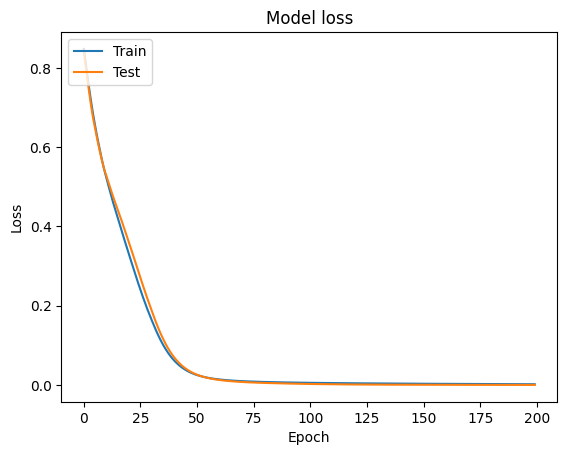

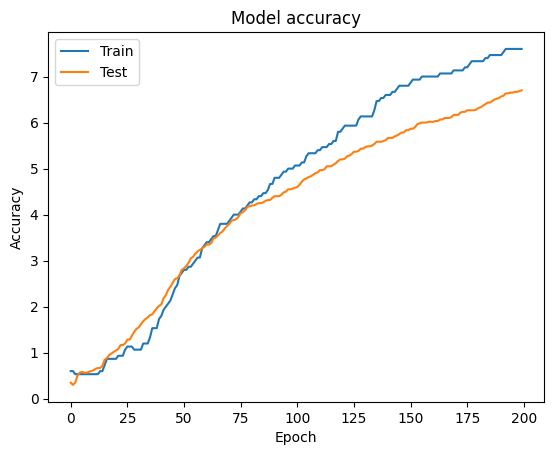

In [198]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(t_loss)
plt.plot(v_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(t_acc)
plt.plot(v_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [199]:
# Evaluate the model accuracy
with torch.no_grad(): # Turn of backpropagation so that evaluation does not affect the model
    y_eval = model(X_test) # Get the predicted y values
    loss = criterion(y_eval, y_test) # Calculate the loss/error

print(f'Loss: {loss}')

Loss: 0.00019216255168430507
